#  Deep LSTM Neural Network 
https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks

Autor do código: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

## O QUE SÃO NEURÔNIOS LSTM?
Um dos problemas fundamentais que atormentaram as arquiteturas de redes neurais tradicionais durante muito tempo foi a capacidade de interpretar sequências de entradas que dependiam umas das outras para informação e contexto. Essas informações podem ser palavras anteriores em uma frase para permitir que um contexto preveja a próxima palavra ou informações temporais de uma sequência que permita o contexto nos elementos baseados na hora dessa sequência.

Simplificando, as redes neurais tradicionais recebem um vetor de dados independente a cada vez e não têm nenhum conceito de memória para ajudá-las em tarefas que precisam de memória.

Uma tentativa inicial de lidar com isso foi usar uma abordagem de tipo de feedback simples para neurônios na rede, onde a saída era inserida de volta na entrada para fornecer contexto nas últimas entradas vistas. Estes foram chamados de Redes Neurais Recorrentes (RNNs). Embora esses RNNs tenham trabalhado até certo ponto, eles tiveram uma queda bastante grande que qualquer uso significativo deles levou a um problema chamado de Vanishing Gradient Problem. Nós não expandiremos a questão do gradiente de desaparecimento além de dizer que os RNNs são mal adaptados na maioria dos problemas do mundo real devido a esse problema; portanto, outra maneira de lidar com a memória de contexto precisava ser encontrada.

Este é o lugar onde a rede neural Long Short Term Memory (LSTM) veio para o resgate. Como os neurônios RNN, os neurônios LSTM mantinham um contexto de memória dentro de seu pipeline para permitir resolver problemas sequenciais e temporais sem a questão do gradiente de fuga afetar seu desempenho.

Muitos artigos e artigos de pesquisa podem ser encontrados on-line, que discutem o funcionamento das células LSTM em grandes detalhes matemáticos. Neste artigo, no entanto, não discutiremos o funcionamento complexo dos LSTMs, pois estamos mais preocupados com seu uso para nossos problemas.

Para o contexto, abaixo está um diagrama do funcionamento interno típico de um neurônio LSTM. Ele consiste em várias camadas e operações pontuais que atuam como portas para entrada, saída e esquecimento de dados que alimentam o estado da célula LSTM. Esse estado da célula é o que mantém a memória e o contexto de longo prazo na rede e nas entradas.

https://www.altumintelligence.com/assets/time-series-prediction-using-lstm-deep-neural-networks/lstm_cell.png

## UM EXEMPLO SIMPLES DE ONDA SENOIDAL
Para demonstrar o uso de redes neurais LSTM na previsão de uma série temporal, vamos começar com a coisa mais básica que podemos pensar que é uma série temporal: a onda sinusoidal confiável. E vamos criar os dados que precisaremos para modelar muitas oscilações dessa função para a rede LSTM treinar.

Os dados fornecidos na pasta de dados do código contém um arquivo sinewave.csv que nós criamos e que contém 5001 períodos de tempo de uma onda senoidal com amplitude e frequência de 1 (dando uma freqüência angular de 6,28) e um delta de tempo de 0,01. O resultado disso, quando plotado, é assim:


In [23]:
import os
import json
import time
import math
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
series = pd.read_csv('sinewave.csv') #leitura do arquivo execel variação de 1 a -1, onda senoidal simples.
series.head()
series.shape #amostra com 5k1 linhas e 1 coluna

(5001, 1)

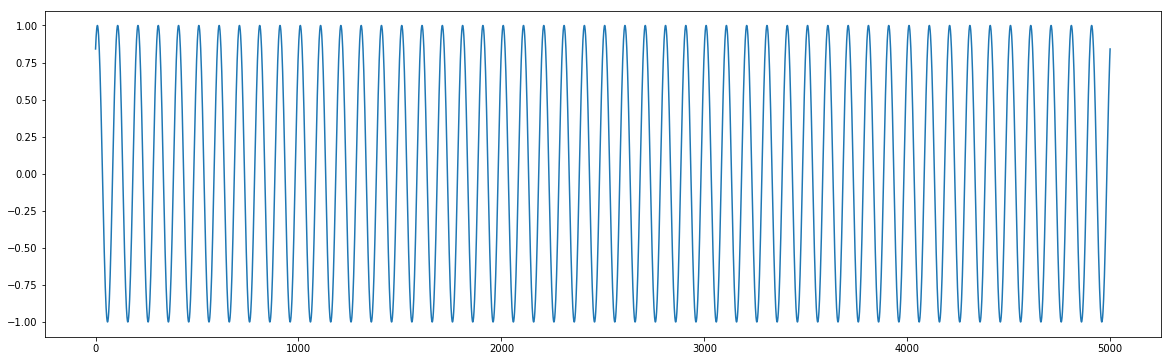

In [25]:
#poltando a senoide
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

Bem, simplesmente queremos que o LSTM aprenda a onda senoidal a partir de um tamanho de janela de conjunto de dados que iremos alimentá-la e esperamos poder solicitar ao LSTM que preveja os próximos N passos da série e manterá a saída de uma onda senoidal. 

    1 -> Carregar os dados em arquivo CSV e transformar em um DataFrame(Pandas)
    2 -> Gerar um array numpy que alimenta o LSTM (precisa de um conjunto numpy de 3 dimensões N(numero seq treinamento), W(comprimento da sequencia), F(numero caracteristica de cada sequencia)).
    3 -> Escolhido comprimento de sequência (tamanho da janela) 50 (obtem uma ideia de como é a forma da onda, para aprender com o passado);
    
As sequências em si são janelas deslizantes e, portanto, mudam de 1 a cada vez, causando uma sobreposição constante com as janelas anteriores. Uma janela de treinamento típica de comprimento de seqüência 50, quando plotada, é:

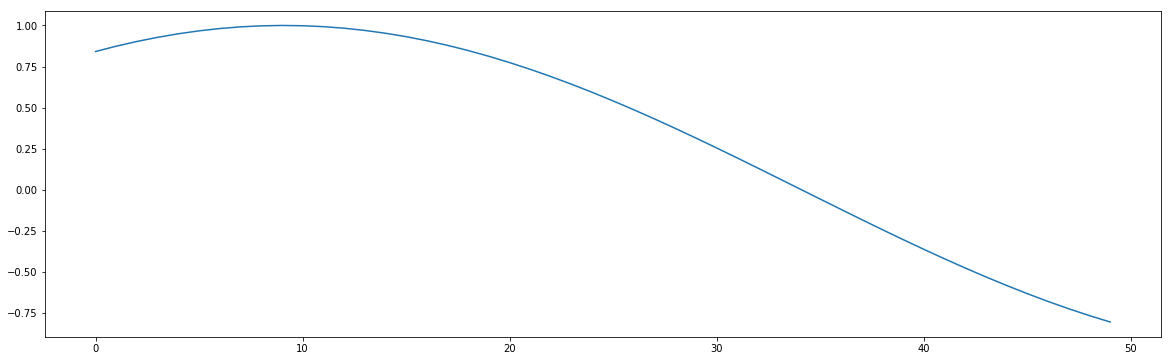

In [26]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values[:50])
pyplot.show()

A classe DataLoader fornecer uma abstração para a camada de carregamento de dados. Você notará que, na inicialização de um objeto DataLoader, o nome do arquivo é passado, juntamente com uma variável de divisão que determina a porcentagem dos dados a serem usados para treinamento versus teste e uma variável de colunas que permite selecionar uma ou mais colunas de dados para análise unidimensional ou multidimensional.

In [27]:
class DataLoader():
    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format				
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

Depois que tiver um objeto de dados que nos permita carregar os dados, é preciso construir o modelo de rede neural profunda. Novamente para abstração a estrutura de código usa uma classe Model ao lado de um arquivo config.json para construir facilmente uma instância do nosso modelo, considerando uma arquitetura e um hiperparâmetros necessários armazenados no arquivo de configuração. A principal função que constrói a nossa rede são as funções build_model () que levam no arquivo de configurações analisadas.
Este código de função pode ser visto abaixo e pode ser facilmente estendido para uso futuro em arquiteturas mais complexas.

In [28]:
class Timer():
    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))


class Model():
    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

        save_fname = 'saved_models/%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs))
        callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)]
        self.model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=callbacks)
        self.model.save(save_fname)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))

        save_fname = 'saved_models/%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs))
        callbacks = [ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]
        self.model.fit_generator(data_gen,steps_per_epoch=steps_per_epoch,epochs=epochs,callbacks=callbacks,workers=1)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def predict_point_by_point(self, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len):
        #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
        prediction_seqs = []
        for i in range(int(len(data)/prediction_len)):
            curr_frame = data[i*prediction_len]
            predicted = []
            for j in range(prediction_len):
                predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        #Shift the window by 1 new prediction each time, re-run predictions on new window
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        return predicted

Com os dados carregados e o modelo construído, agora podemos progredir para treinar o modelo com nossos dados de treinamento. Para isso, criamos um módulo de execução separado que utilizará nossas abstrações Model e DataLoader para combiná-las para treinamento, saída e visualizações.

Abaixo está o código de discussão geral para treinar nosso modelo.

In [37]:
#configs = json.load(open('config_Bolsa.json', 'r')) #como se fosse a bolsa de valores
configs = json.load(open('config.json', 'r')) #senoide
data = DataLoader(os.path.join('', configs['data']['filename']),configs['data']['train_test_split'],configs['data']['columns'])
model = Model()
model.build_model(configs)
x, y = data.get_train_data(seq_len = configs['data']['sequence_length'],normalise = configs['data']['normalise'])
model.train(x,y,epochs = configs['training']['epochs'],batch_size = configs['training']['batch_size'])
x_test, y_test = data.get_test_data(seq_len = configs['data']['sequence_length'],normalise = configs['data']['normalise'])

[Model] Model Compiled
Time taken: 0:00:00.294212
[Model] Training Started
[Model] 2 epochs, 32 batch size
Epoch 1/2
3950/3950 [==============================] - 25s 6ms/step - loss: 0.0381
Epoch 2/2
  32/3950 [..............................] - ETA: 22s - loss: 8.7763e-04

C:\Users\miche\Anaconda3\lib\site-packages\keras\callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\miche\Anaconda3\lib\site-packages\keras\callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3950/3950 [==============================] - 23s 6ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/08092018-152542-e2.h5
Time taken: 0:00:49.929074


Depois do treinamento realizado, será executado duas formas de previsão:
    
    1->Previsão de um ponto a ponto: estamos prevendo apenas um único ponto à frente de cada vez, plotando esse ponto como uma previsão e, em seguida, tomando a próxima janela com os dados completos de teste e prevendo o próximo ponto novamente.
    2->Previsao de uma sequência completa: por isso apenas inicializamos uma janela de treino com a primeira parte dos dados de treino uma vez. O modelo então prevê o próximo ponto e nós mudamos a janela, como no método ponto a ponto. A diferença é, então, prever usando os dados que previmos na previsão anterior. Na segunda etapa, isso significará que apenas um ponto de dados (o último ponto) será da previsão anterior. Na terceira previsão, os dois últimos pontos de dados serão de previsões anteriores e assim por diante. Depois de 50 previsões, o nosso modelo irá subsequentemente prever as suas próprias previsões anteriores. Isso nos permite usar o modelo para prever muitas etapas de tempo à frente,

Abaixo, podemos ver o código e as respectivas saídas para as previsões ponto-a-ponto e as previsões de sequência completa:

In [38]:
def predict_point_by_point(self, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = self.model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(self, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    return predicted

predictions_pointbypoint = model.predict_point_by_point(x_test)
predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])

Text(0.5,1,'Modelo sobreposto')

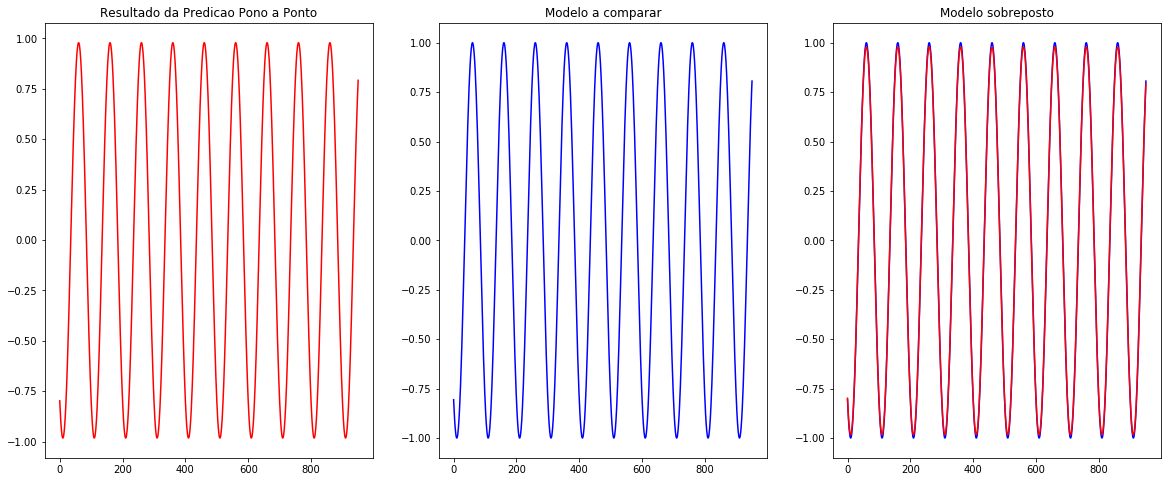

In [39]:
fig, ax = pyplot.subplots(1,3, figsize=(20,8))
ax[0].plot(predictions_pointbypoint,'r-')
titulo = 'Resultado da Predicao Pono a Ponto'
ax[0].set_title(titulo)

ax[1].plot(y_test,'b-')
titulo = 'Modelo a comparar'
ax[1].set_title(titulo)

ax[2].plot(y_test,'b-')
ax[2].plot(predictions_pointbypoint,'r-')
titulo = 'Modelo sobreposto'
ax[2].set_title(titulo)


Text(0.5,1,'Modelo sobreposto')

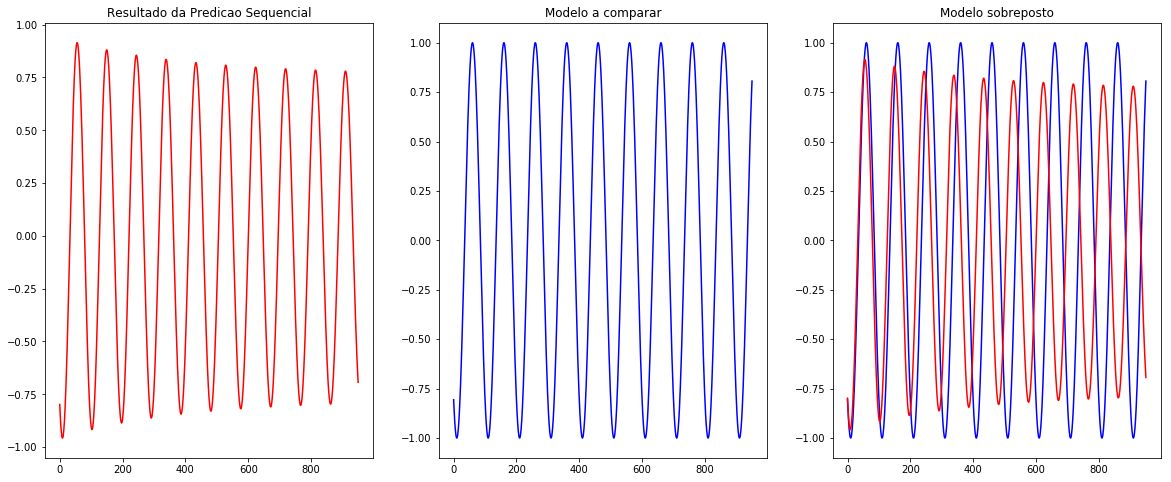

In [40]:
fig, ax = pyplot.subplots(1,3, figsize=(20,8))
ax[0].plot(predictions_fullseq,'r-')
titulo = 'Resultado da Predicao Sequencial'
ax[0].set_title(titulo)

ax[1].plot(y_test,'b-')
titulo = 'Modelo a comparar'
ax[1].set_title(titulo)

ax[2].plot(y_test,'b-')
ax[2].plot(predictions_fullseq,'r-')
titulo = 'Modelo sobreposto'
ax[2].set_title(titulo)


Sobrepostos aos dados verdadeiros, podemos ver que, com apenas 1 época e um conjunto de dados de treinamento razoavelmente pequeno, a rede neural profunda do LSTM já fez um bom trabalho de prever a função seno.

Você pode ver que à medida que prevemos cada vez mais no futuro, a margem de erro aumenta à medida que os erros nas previsões anteriores são amplificados cada vez mais quando são usados para previsões futuras. Como tal, vemos que, no exemplo da sequência completa, quanto mais longe no futuro, prevemos que a frequência e a amplitude das previsões são menos precisas em comparação com os dados verdadeiros. No entanto, como a função sin é uma função oscilante muito fácil com ruído zero, ela ainda pode prever um bom grau sem overfitting - isso é importante, já que poderíamos facilmente ajustar o modelo aumentando as épocas e removendo as camadas de dropout para torná-lo quase perfeitamente precisos sobre esses dados de treinamento, que é do mesmo padrão que os dados de teste.

## Implementando a conclusão do autor

In [42]:
configs = json.load(open('config_SemDropOut_6Epocas.json', 'r')) #Senoide, com 6 épocas e sem as camadas de dropout
data = DataLoader(os.path.join('', configs['data']['filename']),configs['data']['train_test_split'],configs['data']['columns'])
model = Model()
model.build_model(configs)
x, y = data.get_train_data(seq_len = configs['data']['sequence_length'],normalise = configs['data']['normalise'])
model.train(x,y,epochs = configs['training']['epochs'],batch_size = configs['training']['batch_size'])
x_test, y_test = data.get_test_data(seq_len = configs['data']['sequence_length'],normalise = configs['data']['normalise'])

def predict_point_by_point(self, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = self.model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(self, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    return predicted

predictions_pointbypoint = model.predict_point_by_point(x_test)
predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])

[Model] Model Compiled
Time taken: 0:00:00.284213
[Model] Training Started
[Model] 6 epochs, 32 batch size
Epoch 1/6
3950/3950 [==============================] - 26s 7ms/step - loss: 0.0292
Epoch 2/6


C:\Users\miche\Anaconda3\lib\site-packages\keras\callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\miche\Anaconda3\lib\site-packages\keras\callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3950/3950 [==============================] - 27s 7ms/step - loss: 9.2492e-06: 9s - l - ETA: 6s  - ETA: 2s - loss: 
Epoch 3/6
3950/3950 [==============================] - 23s 6ms/step - loss: 1.5151e-06
Epoch 4/6
3950/3950 [==============================] - 24s 6ms/step - loss: 6.6402e-07
Epoch 5/6
3950/3950 [==============================] - 24s 6ms/step - loss: 4.4523e-07: 3
Epoch 6/6
3950/3950 [==============================] - 25s 6ms/step - loss: 3.9084e-07
[Model] Training Completed. Model saved as saved_models/08092018-152841-e6.h5
Time taken: 0:02:31.157820


Text(0.5,1,'Modelo sobreposto')

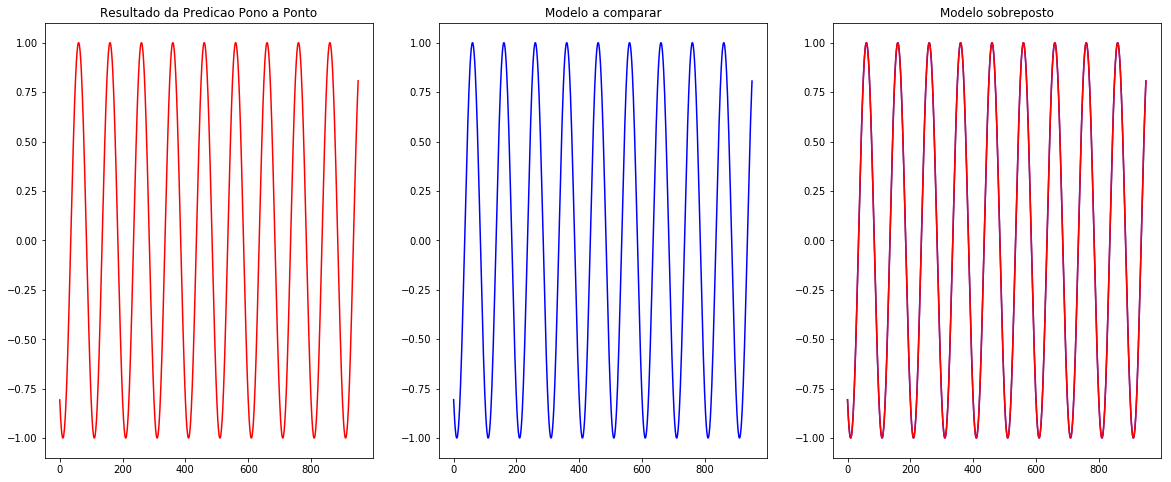

In [43]:
fig, ax = pyplot.subplots(1,3, figsize=(20,8))
ax[0].plot(predictions_pointbypoint,'r-')
titulo = 'Resultado da Predicao Pono a Ponto'
ax[0].set_title(titulo)

ax[1].plot(y_test,'b-')
titulo = 'Modelo a comparar'
ax[1].set_title(titulo)

ax[2].plot(y_test,'b-')
ax[2].plot(predictions_pointbypoint,'r-')
titulo = 'Modelo sobreposto'
ax[2].set_title(titulo)

Text(0.5,1,'Modelo sobreposto')

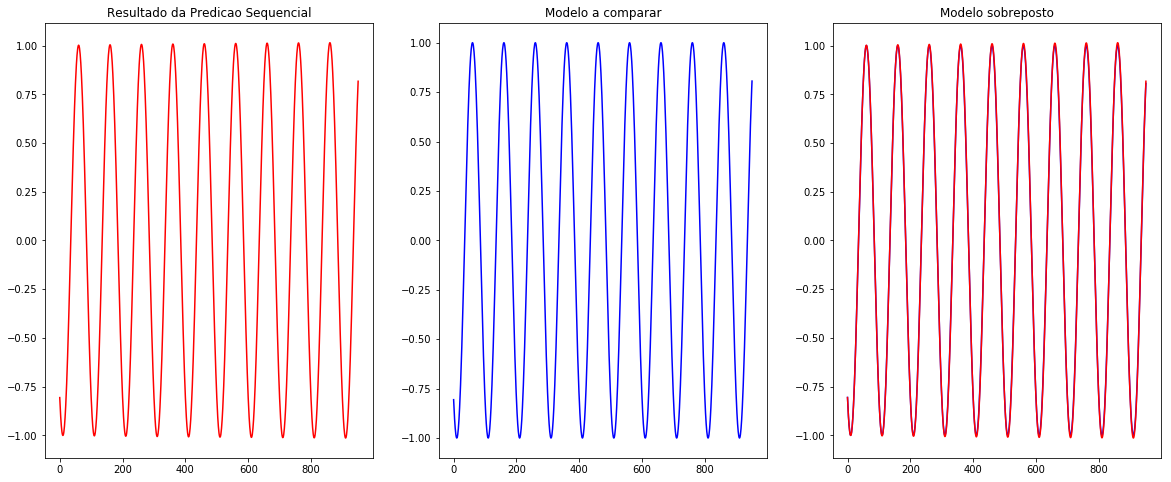

In [44]:
fig, ax = pyplot.subplots(1,3, figsize=(20,8))
ax[0].plot(predictions_fullseq,'r-')
titulo = 'Resultado da Predicao Sequencial'
ax[0].set_title(titulo)

ax[1].plot(y_test,'b-')
titulo = 'Modelo a comparar'
ax[1].set_title(titulo)

ax[2].plot(y_test,'b-')
ax[2].plot(predictions_fullseq,'r-')
titulo = 'Modelo sobreposto'
ax[2].set_title(titulo)

# O MERCADO DE AÇÕES NÃO TÃO SIMPLES